In [1]:
import importlib
import time

import numpy as np

import wumpus
import aufgabe2
import aufgabe2_mike
import aufgabe2_friend
import agents

In [2]:
def render_one_episode(agent: agents.AgentV2, env: wumpus.Wumpus):
    import time
    agent.new_episode()

    terminated = False
    percept = env.reset()
    total_reward = 0
    reward = 0
    while not terminated:
        action = agent.get_action(percept, reward)
        display(env.render(), clear=True)
        print(action)
        time.sleep(0.5)
        percept, reward, terminated, info = env.step(action)
        total_reward += reward
    print(f"episode finished with reward {total_reward}")

def test_agent(
    agent: agents.AgentV2,
    env: wumpus.Wumpus,
    n_repeat = 100,
    return_full = False,
):
    cum_rewards = np.zeros(n_repeat)

    for run in range(n_repeat):
        agent.new_episode()
        terminated = False
        percept = env.reset()
        reward = 0
        while not terminated:
            action = agent.get_action(percept, reward)
            percept, reward, terminated, info = env.step(action)
            cum_rewards[run] += reward

    if return_full:
        return cum_rewards
    average_total_reward = np.mean(cum_rewards)
    return average_total_reward


In [3]:
importlib.reload(aufgabe2)
importlib.reload(aufgabe2_mike)
size = (4, 4)
env = wumpus.Wumpus(seed=2025, size=size, p_pit=0.)

# agent = agents.AgentV2(size=size)
# agent = aufgabe2.Agent(size=size)
# agent = aufgabe2_friend.Agent(size=size)
agent = aufgabe2_mike.Agent(size=size)

In [42]:
test_agent(agent, env)

-1059.0

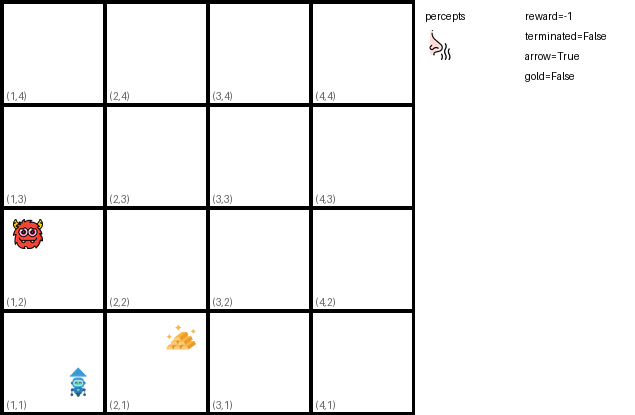

1
episode finished with reward -1049


In [17]:
render_one_episode(agent, env)

In [197]:
import importlib
import numpy as np
import aufgabe2_mike
importlib.reload(aufgabe2_mike)

import stable_baselines3
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

def export_ppo_to_string(agent: stable_baselines3.PPO, dtype=np.float32):
    import itertools

    weights = []
    biases = []

    iter1 = agent.policy.get_submodule("mlp_extractor").get_submodule("policy_net").named_children()
    iter2 = agent.policy.get_submodule("action_net").named_modules()
    for name, param in itertools.chain(iter1, iter2):
        # print(name, param)
        for p in param.parameters():
            m = p.detach().numpy().transpose()
            m = m.astype(dtype=dtype)
            if len(m.shape) == 2:
                weights.append(m)
            elif len(m.shape) == 1:
                biases.append(m)

    layers = [w.shape[1] for w in weights[:-1]]
    input_dim = weights[0].shape[0]
    output_dim = weights[-1].shape[1]

    net = aufgabe2_mike.NeuralNetwork(input_dim, output_dim, layers)
    net.weights = weights
    net.biases = biases

    return net.to_string()

def save_to_clipboard(text: str):
    import os
    command = 'echo | set /p nul=' + text.strip() + '| clip'
    os.system(command)

def render_one_episode_gym(
    agent: stable_baselines3.PPO, env: aufgabe2_mike.WumpusEnv, deterministic=True
):
    import time
    done = False
    total_reward = 0
    obs, _ = env.reset()
    for i in range(1000):
        display(env.render(), clear=True)
        a = agent.predict(obs, deterministic=deterministic)[0]
        print(a)
        time.sleep(0.5)
        obs, r, done, _, _ = env.step(a)
        total_reward += r
        if done:
            break
    print(f"Episode done. Total reward: {total_reward:.2f}")

size = (4, 4)
p_pit = 0.
with_wumpus = True
time_max = 100

env_fn_easy_v1 = lambda: Monitor(aufgabe2_mike.WumpusEnv(
    size=size, p_pit=0., seed=None, Tmax=time_max, with_wumpus=False,
))
env_fn_easy_v2 = lambda: Monitor(aufgabe2_mike.WumpusEnv(
    size=size, p_pit=0., seed=None, with_wumpus=False, Tmax=(10, 100)
))
env_fn_easy_v3 = lambda: Monitor(aufgabe2_mike.WumpusEnv(
    size=size, p_pit=0., seed=None, Tmax=(90, 100), with_wumpus=False, start_pos=None, start_orientation=None
))
env_fn_easy_v4 = lambda: Monitor(aufgabe2_mike.WumpusEnv(
    size=size, p_pit=0., seed=None, Tmax=(10, 100), with_wumpus=False, start_pos=None, start_orientation=None
))
env_fn_medium_v1 = lambda: Monitor(aufgabe2_mike.WumpusEnv(
    size=size, p_pit=0., seed=None, Tmax=time_max, with_wumpus=True, #start_pos=None, start_orientation=None
))
env_fn_medium_v2 = lambda: Monitor(aufgabe2_mike.WumpusEnv(
    size=size, p_pit=0., seed=None, Tmax=(40, 80), with_wumpus=True,
))
env_fn_hard_v1 = lambda: Monitor(aufgabe2_mike.WumpusEnv(
    size=size, p_pit=0.05, seed=None, Tmax=time_max, with_wumpus=False,
))
env_fn_hard_v2 = lambda: Monitor(aufgabe2_mike.WumpusEnv(
    size=size, p_pit=(0.05, 0.20), seed=None, Tmax=(40, 100), with_wumpus=False,
))
env_fn_expert_v1 = lambda: Monitor(aufgabe2_mike.WumpusEnv(
    size=size, p_pit=0.05, seed=None, Tmax=time_max, with_wumpus=True, #start_pos=None, start_orientation=None
))
env_fn_expert_v2 = lambda: Monitor(aufgabe2_mike.WumpusEnv(
    size=size, p_pit=(0.05, 0.20), seed=None, Tmax=(40, 100), with_wumpus=True,
))
env_fn_validation = lambda: Monitor(aufgabe2_mike.WumpusEnv(
    size=size, p_pit=0.20, seed=None, Tmax=50,
))

In [6]:
importlib.reload(aufgabe2_mike)
# vec_env = make_vec_env(env_fn_easy, n_envs=64)
# vec_env = DummyVecEnv([env_fn_easy_v1] * 16 + [env_fn_medium_v1] * 48)
# vec_env = DummyVecEnv([env_fn_easy_v2] * 16 + [env_fn_medium_v1] * 48)
# vec_env = DummyVecEnv([env_fn_easy_v2] * 16 + [env_fn_medium_v1] * 46 + [env_fn_hard_v1] * 2)
vec_env = DummyVecEnv([env_fn_easy_v2] * 8 + [env_fn_medium_v2] * 46 + [env_fn_hard_v1] * 10)
# vec_env = DummyVecEnv([env_fn_easy_v2] * 16 + [env_fn_medium_v2] * 92 + [env_fn_hard_v1] * 20)
# vec_env = DummyVecEnv([env_fn_easy_v2] * 16 + [env_fn_medium_v2] * 64 + [env_fn_hard_v1] * 48)

In [7]:
env = env_fn_easy_v1()
env.reset()
env.step(0)
env.step(0)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]),
 -0.2,
 False,
 False,
 {})

In [8]:
import torch
policy_kwargs = dict(
    net_arch=[128, 128],
    activation_fn=torch.nn.Tanh,                     
    optimizer_class=torch.optim.AdamW,
    optimizer_kwargs=dict(weight_decay=2e-2),
)
agent = stable_baselines3.PPO(
    "MlpPolicy",
    vec_env,
    learning_rate=1e-3,
    batch_size = 512,
    ent_coef=0.03,
    verbose=1,
    stats_window_size=1000,
    policy_kwargs=policy_kwargs,
)

Using cpu device


In [ ]:
torch.set_num_threads(1)
agent.learn(total_timesteps=6_000_000, log_interval=1)

In [ ]:
# agent.save("ppo_wumpus")
# agent = stable_baselines3.PPO.load("ppo_wumpus", env=vec_env)
# agent.set_parameters("ppo_wumpus")
# from pandas.io import clipboard
# clipboard.copy(f'"{export_ppo_to_string(agent, np.float16)}"')

In [ ]:
# vec_env_ = vec_env
# vec_env = DummyVecEnv([env_fn_easy] * 0 + [env_fn_medium] * 0 + [env_fn_hard] * 64)
# env_fn = lambda: aufgabe2_mike.WumpusEnv(size=(4,4), p_pit=0.1, seed=None, with_wumpus=True)
# vec_env_ = make_vec_env(env_fn, n_envs=64)
mean, std = stable_baselines3.common.evaluation.evaluate_policy(
    agent, vec_env, n_eval_episodes=5_000, deterministic=False
)
print(f"{mean:.2f} +/- {std:.2f}")

87.19 +/- 52.53


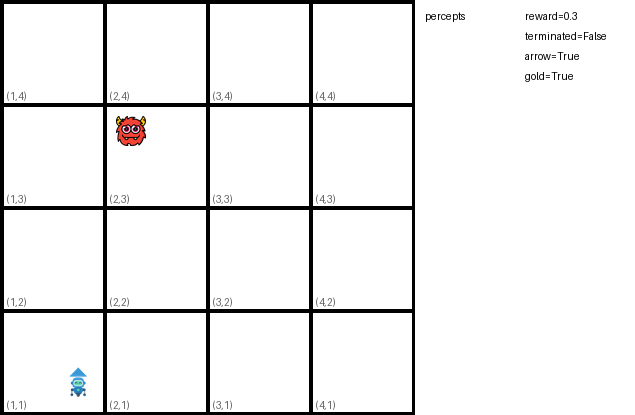

5
Episode done. Total reward: 115.40


In [10]:
# 6
# env = aufgabe2_mike.WumpusEnv(seed=6)
# env = env_fn_hard_v1()
env = aufgabe2_mike.WumpusEnv(size=(4,4), p_pit=0., seed=None, with_wumpus=True)
render_one_episode_gym(agent, env, deterministic=False)

In [ ]:
# check model weights norm
weights_norm = []
for param in agent.policy.parameters():
    try:
        weights_norm.append(torch.norm(param).item())
    except:
        pass
print(sum(weights_norm))